In [ ]:
#ignore the warnings
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
load_dotenv()
GROQ_API_KEY = os.environ.get("GROQ_API_KEY")

# Initilize the LLM
llm =ChatGroq(model ="llama-3.3-70b-versatile")

#Set the Cache
from langchain_core.caches import InMemoryCache
from langchain_core.globals import set_llm_cache
set_llm_cache(InMemoryCache())

In [10]:
# Define the shared graph state
from typing import TypedDict, Literal,List,Annotated
from langgraph.graph import add_messages

class State(TypedDict):
    message:str
    feedback:Annotated[List[str],add_messages]
    response:Annotated[List[str],add_messages]

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

def Model(state: State):
    # Get the latest message and decision safely
    
    feedback = state["feedback"][-1] if state["feedback"] else "No previous feedback"

    prompt = f"""
You are an expert Fiverr proposal writer skilled in crafting winning, client-focused proposals.  
Your goal is to write a professional, customized Fiverr proposal based on the user's project description.

Instructions:
- Carefully read the user's project requirements.  
- Write a clear, engaging, and persuasive proposal under 100 words.  
- Emphasize Amir Ali’s expertise in AI, Data Science, Machine Learning, Deep Learning, NLP, Generative AI, and Agentic AI.  
- Maintain a confident, friendly, and professional tone that inspires trust.  
- If previous feedback is available, naturally incorporate it into the new proposal.  
- Avoid generic phrases like “I can do this job perfectly” — focus instead on *value, understanding, and results.*

User Project Details:
{state["message"]}

Previous Feedback:
{feedback}

Example Proposals for Reference:
1. "Hi there! I’ll develop a powerful AI-driven solution tailored to your needs. With 3+ years of experience in Machine Learning and NLP, I’ll ensure accurate, efficient, and scalable results. Let’s turn your idea into reality!"

2. "Hello! I specialize in building intelligent systems using Deep Learning and Generative AI. I’ll design a custom model to meet your exact project goals with clear documentation and ongoing support."

Now, write the best Fiverr proposal for the given project.
"""


    # Invoke the LLM
    result = llm.invoke([
        SystemMessage(content="You are a professional Fiverr proposal writer who crafts personalized, persuasive, and concise proposals under 100 words based on user requirements and feedback"),
        HumanMessage(content=prompt)
    ])

    response_text = result.content

    print("Response",response_text)

    # Return updated state
    return {
        "response": [AIMessage(content=response_text)],
    }

In [12]:
from langgraph.types import Command,interrupt
# Human approval node
def Human_approval(state:State) -> Command[Literal["approved_path","model"]]:
    user_feedback=interrupt({
        "question":"Do you approve this response?",
        "response":state["response"]
    })

    if user_feedback == "done":
        return Command( update={"feedback":state["feedback"]}, goto = "approved_path")
    
    return Command(update={"feedback":state["feedback"] + [user_feedback]}, goto="model")


In [13]:
def approved_node(state:State):
    
    feedback=state['feedback']

    print("Final response :",state['response'][-1])
    print("Human Feedback ",feedback)

    return {
        "response":state['response'][-1],
        "feedback":feedback
    }

In [14]:
from langgraph.graph import START,StateGraph,END
from langgraph.checkpoint.memory import InMemorySaver

workflow=StateGraph(State)

workflow.add_node("model",Model)
workflow.add_node("Human_approval",Human_approval)
workflow.add_node("approved_path",approved_node)


workflow.add_edge(START,"model")
workflow.add_edge("model","Human_approval")
workflow.add_conditional_edges("Human_approval",Human_approval)
workflow.add_edge("approved_path",END)

checkpointer=InMemorySaver()
graph=workflow.compile(checkpointer=checkpointer)

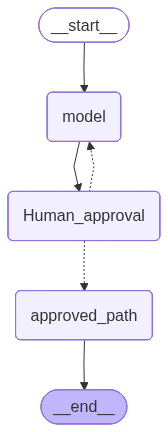

In [15]:
from IPython.display import Image,display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [17]:
import uuid
thread_config = {"configurable": {
    "thread_id": uuid.uuid4()
}}

#message = input("Enter your proposal requirements:")

message="""
Developed and optimized a LangChain and LangGraph-based
multi-agent system for intelligent workflow orchestration.
Designed context-aware reasoning flows, implemented dynamic
RAG pipelines, and integrated LLM-powered agents for complex
task execution. Delivered a scalable and production-ready 
framework enabling seamless communication between multiple AI
agents and APIs.
"""

initial_state = {
    "message": message, 
    "response": [], 
    "feedback": []
}

for chunk in graph.stream(initial_state, config=thread_config):
    for node_id, value in chunk.items():
        #  If we reach an interrupt, continuously ask for human feedback

        if(node_id == "__interrupt__"):
            while True: 
                user_feedback = input("Provide feedback (or type 'done' when finished): ")

                # Resume the graph execution with the user's feedback
                graph.invoke(Command(resume=user_feedback), config=thread_config)

                # Exit loop if user says done
                if user_feedback.lower() == "done":
                    break

Response  "Hi, I'm Amir Ali. I'll optimize your multi-agent system using LangChain and LangGraph, leveraging my expertise in AI, Data Science, and NLP. I'll refine context-aware reasoning flows and dynamic RAG pipelines, ensuring seamless communication between AI agents and APIs, and delivering a scalable framework for intelligent workflow orchestration."


Task Human_approval with path ('__pregel_pull', 'Human_approval') wrote to unknown channel branch:to:Command(update={'feedback': [HumanMessage(content='Yes, I will do this perfectly. and deliever in the 5 days.', additional_kwargs={}, response_metadata={}, id='dfd0afe3-ef9e-4ffe-bfda-91d9628227e1')]}, goto='approved_path'), ignoring it.


Response  "Hi! I'm Amir Ali, expert in AI, Data Science, and Machine Learning. I'll develop and optimize a LangChain and LangGraph-based multi-agent system, leveraging my expertise in NLP and Generative AI to deliver a scalable and production-ready framework for seamless AI agent and API communication, exceeding your expectations."
